In [1]:
# Read in the dataframe
import pickle
import pandas as pd
import numpy as np

df = pd.read_pickle("script_df.pkl")
df.head()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id
0,1,1,Dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1
1,1,2,McGonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1
2,1,3,Dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1
3,1,4,McGonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1
4,1,5,Dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1


In [190]:
# Lets first fix the characters So they all have lower_case letters
df['character'] = df['character'].str.lower()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id
0,1,1,dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1
1,1,2,mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1
2,1,3,dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1
3,1,4,mcgonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1
4,1,5,dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1


In [194]:
# df[df.sentence != ''].groupby('character').size()
sentence_count = df[df.sentence != ''].groupby('character').size()
sentence_count_limit = sentence_count[sentence_count > 2]

In [ ]:
# some general last fixing 
mapping_voldemort = {'voldemort':['voldermort','tom riddle']}

In [195]:
sentence_count_limit

character
(more )                  3
(more)                   8
(v.o.)                   8
aberforth               19
afternoon                3
                        ..
wood                    16
wormtail                10
xenophilius lovegood    25
yaxley                   8
young hagrid             6
Length: 173, dtype: int64

In [149]:
# Lets create a dictionary with the total text by each character:
# df.character[(df.sentence != '')
char = 'dobby'
df.sentence[df.character.str.lower() == 'dobby'].str.cat(sep=' ')

"Harry Potter! Such an honor it is! Dobby, sir. Dobby the house elf. Oh, yes, sir, Dobby understands. It's just that, Dobby has come to tell you... it is difficult, sir... Dobby wonders where to begin. S-s-sit down? Offend Dobby! Dobby has heard of your greatness, sir, but never has he been asked to sit down by a wizard, like an equal... Bad Dobby! Bad Dobby! Dobby had to punish himself, sir. Dobby almost spoke ill of his family, sir. The wizard family Dobby serves, Sir. Dobby is bound to serve one family forever. If they ever knew Dobby was here... But Dobby had to come. Dobby has to protect Harry Potter. To warn him. This is a plot. A plot to make most terrible things happen. If Harry Potter goes back to school he will be in great danger. Friends who don't even write to Harry Potter? Harry Potter mustn't be angry with Dobby -- Dobby hoped if Harry Potter thought his friends had forgotten him... Harry Potter might not want to go back to school, Sir... Harry Potter must say he's not go

In [141]:
test = df[df.movie_nr == 1].groupby(['character'])['sentence']
len(test[test.index == 'Harry'])

1

In [ ]:
# lets create connection between characters 

# for movie in df.movie_nr:
movie = 1
# df_names = df['character'].unique()
df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()

con_scene = dict()
for scene in df_store:
    print("Scene length:",len(scene))
    for idx in range(len(scene)-1):
        for idx2 in range(idx+1,len(scene)):
            print(scene[idx],scene[idx2])
            if (scene[idx],scene[idx2]) in con_str:
                con_str[(scene[idx],scene[idx2])] += 1
            else:
                con_str[(scene[idx],scene[idx2])] = 1

In [89]:
# con_scene_desc = dict()
# for movie in df.movie_nr:
movie = 1
# df_names = df['character'].unique()
df_store = df[df.movie_nr == movie].groupby(['scene_desc','movie_nr'])['character'].unique()

con_scene = dict()
for scene in df_store:
    for idx in range(len(scene)-1):
        for idx2 in range(idx+1,len(scene)):
            if (scene[idx],scene[idx2]) in con_str:
                con_str[(scene[idx],scene[idx2])] += 1
            else:
                con_str[(scene[idx],scene[idx2])] = 1

In [101]:
df[df.char != ''].character.unique()

array(['Dumbledore', 'McGonagall', 'Hagrid', 'Petunia', 'Dudley',
       'Vernon', 'Harry', 'Snake', 'Man', 'All', 'Tom', 'Witch',
       'Quirrell', 'Boy', 'Goblin', 'Griphook', 'Ollivander',
       'Trainmaster', 'George', 'Fred', 'Ron', 'Woman', 'Frog',
       'Hermione', 'Neville', 'Draco', 'Seamus', 'Percy', 'Nick', 'Girl',
       'Snape', 'Hooch', 'Class', 'Students', 'Filch', 'Oliver',
       'Flitwick', 'OIiver', 'Lee', 'Gryffindors', 'Flint', 'Crowd',
       'Firenze', 'Voldemort', 'HARRY', 'UNCLE VERNON', 'DUDLEY',
       'AUNT PETUNIA', 'DOBBY', 'MR. MASON', 'SAME SCENE - LATER', 'RON',
       "CLOSEUP - HARRY'S TRUNK 13B", "INSERT - FRED'S FOOT 13C", 'FRED',
       'MRS. WEASLEY', 'GINNY', 'GEORGE', 'MR. WEASLEY',
       'HARRY /RON/FRED/GEORGE', 'PERCY', 'MR. BORGIN', 'LUCIUS MALFOY',
       'DRACO', 'AGED WITCH', 'HAGRID', 'HERMIONE', 'SHORT MAN',
       'GILDEROY LOCKHART', 'GUARD', 'HARRY /RON', 'FILCH', 'SNAPE',
       'ALBUS DUMBLEDORE', 'DUMBLEDORE', 'NEVILLE', 'SEAM

In [103]:
df[['sentence','movie_nr']][df.character == 'RON/HERMIONE/MRS. WEASLEY']

,sentence,movie_nr
6169,Harry!,6


In [ ]:
# Skoða sentiment á setningum 

# SKoða sentiment á scenes 

# SKoða sentiment sérstakra karaktera 

# Skoða tengst karaktera m.v. scene eða röðun (fyrir og eftir), ef character kemur fyrir og eftir þá tala þeir sama t.d.

# Create wordclous out of sentences with the outlines of the characters 

# Create a quiz where you get a sentence from character and guess who it was.

In [41]:
import random
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
import itertools
import pickle
import math
from wordcloud import WordCloud, ImageColorGenerator
sns.set()

In [152]:
# Lets combine all sentences of characters into a dictionary
stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()
char_sentences = dict()
for character in df.character.str.lower().unique():
    text = df.sentence[df.character.str.lower() == character.lower()].str.cat(sep=' ')
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    #     harry_freq = nltk.FreqDist(lem_words)
    char_sentences[character] = lem_words

In [159]:
# Lets calculate the sentiment for each characters based on all their sentences 
import csv
sentiments = {}
with open('data/Data_Set_S1.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        if len(row) == 8 and row[0] != "word": # skipping the first lines
            sentiments[row[0].lower()] = float(row[2]) # storing the average sentiment

In [207]:
# Calculate the average sentiment for each characters 
def sentiment(freqdist,cut_off=False):
    sentim_words = [w for w in freqdist.keys() if sentiments.get(w)] # get all word that are in sentiment list
    sentim_values = [sentiments[val]*freqdist[val] for val in sentim_words] # get the value and multiplay by frequency
    sentim_words_freq = sum([freqdist[w] for w in sentim_words]) # total occurances of all valid sentim words
    if cut_off:
        if sentim_words_freq > cut_off: # only take in words that have certin frequency of sentimental words
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None
    else:
        if len(sentim_words) > 0:
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None

In [ ]:
# Get average sentiment for all sentences of character
char_sentiment = {}
for char in char_sentences:
    sentiment_for_char = sentiment(nltk.FreqDist(char_sentences[char]))
    if sentiment_for_char:
        char_sentiment[char] = sentiment_for_char

In [177]:
np.mean(list(char_sentiment.values()))

5.485493892712103

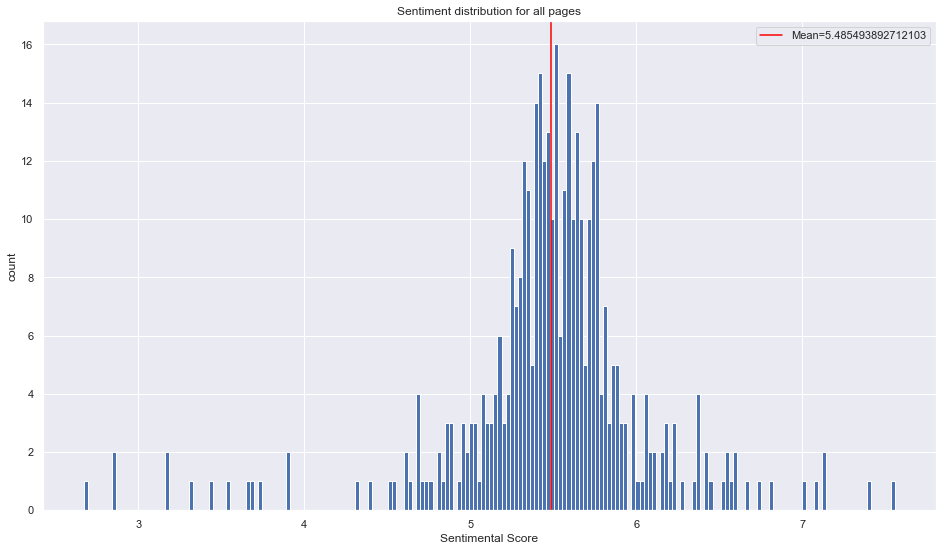

In [178]:
#Create a histogram of all character's associated page-sentiments.
import numpy as np 

plt.figure(figsize=(16,9))
plt.hist(char_sentiment.values(),bins=200)
sent_mean = np.mean((list(char_sentiment.values())))
plt.axvline(x=sent_mean, label=f'Mean={sent_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

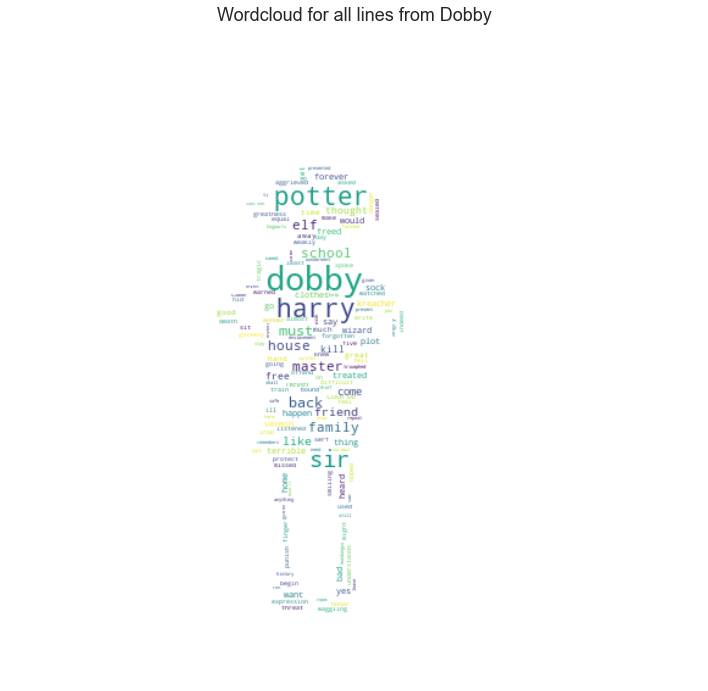

In [107]:
from os import path
from PIL import Image
import os

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
hp_mask = np.array(Image.open(path.join(d, "data/char_images/dobby.jpg")))

# Define the settings and input to the wordclouds - DC
wordcloud_all_books = WordCloud(background_color='white',   
                         width=1000,
                         max_words=2000,
                         height=1000, 
                         colormap="viridis",
                         mask = hp_mask,
                         random_state = 42
                         #contour_width=1, 
                         #contour_color='steelblue'
                        ).generate_from_frequencies(harry_freq)

plt.figure(figsize=(10,10))

plt.imshow(wordcloud_all_books, interpolation='bilinear')
plt.title("Wordcloud for all lines from Dobby", fontsize=18)
plt.axis("off")
plt.tight_layout()

In [213]:
# Lets see how the sentiment changes over time, this is done by creating a moving average of the sentiments for all characters
def token_getsent(text):
    #lets toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    
    # Get the sentiment score
    return(sentiment(nltk.FreqDist(lem_words)))
    

# df['sent_sentence'] = [x for x in ] 

df['sentence_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)
df['scene_desc_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)

# lets add the average sentence sentiment for each scene_id
df['avg_scene_sent'] = df.groupby(['scene_id'])['sentence_sent'].transform('mean')
df['avg_scene_desc_sent'] = df.groupby(['scene_id'])['scene_desc_sent'].transform('mean')

In [214]:
df.head()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id,sent_sentence,avg_scene_sent,sentence_sent,scene_desc_sent,avg_scene_desc_sent
0,1,1,dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1,5.740,5.486298,5.740,5.740,5.486298
1,1,2,mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1,6.685,5.486298,6.685,6.685,5.486298
2,1,3,dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1,4.635,5.486298,4.635,4.635,5.486298
3,1,4,mcgonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1,6.240,5.486298,6.240,6.240,5.486298
4,1,5,dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1,6.040,5.486298,6.040,6.040,5.486298


In [217]:
df.isna()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id,sent_sentence,avg_scene_sent,sentence_sent,scene_desc_sent,avg_scene_desc_sent
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9028,False,False,False,False,False,False,False,False,False,False,False
9029,False,False,False,False,False,False,False,False,False,False,False
9030,False,False,False,False,False,False,True,False,True,True,False
9031,False,False,False,False,False,False,True,False,True,True,False


In [181]:
# function to plot moving average 

def m_avg(values,N): # takes in the values and the N of average (how many values to use)
    size = len(values)
    if size-N < 2:
        return(f'Short list or N too big.')
    else:
        cumsum, moving_aves = [0], []

        for i, x in enumerate(values, 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                
                # add the the average vector
                moving_aves.append(moving_ave)
    return(moving_aves)

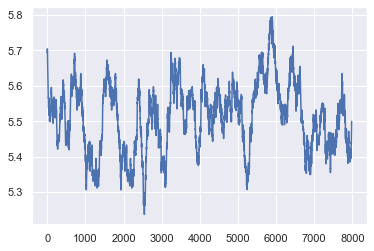

In [223]:
# m_avg(df.sent_sentence.dropna(),10)
plt.plot(m_avg(df.sent_sentence.dropna(),150))

In [227]:
df['character'][df.movie_nr == 3].value_counts()[:50].index.tolist() # get 20 most occuring characters 

['harry',
 'ron',
 'hermione',
 'professor lupin',
 'dumbledore',
 'hagrid',
 'gilderoy lockhart',
 'snape',
 'tom riddle',
 'draco',
 'sirius black',
 'lucius malfoy',
 'uncle vernon',
 'dobby',
 'cornelius fudge',
 'fred',
 'professor trelawney',
 'mrs. weasley',
 'neville',
 'george',
 'aunt marge',
 'stan shunpike',
 'moaning myrtle',
 'seamus',
 'ginny',
 'aunt petunia',
 'madam rosmerta',
 'arthur weasley',
 'mr. weasley',
 'filch',
 'voice',
 'pettigrew',
 'wood',
 'aragog',
 'madam pomfrey',
 'harry /ron',
 'percy',
 'dudley',
 'mr. borgin',
 'dean thomas',
 'shrunken head',
 'professor sprout',
 'colin',
 'ernie',
 'sir cadogan',
 'lavender',
 'fudge',
 'young hagrid',
 'hannah',
 'parvati']

In [227]:
df['character'][df.movie_nr == 3].value_counts()[:50].index.tolist() # get 20 most occuring characters 

['harry',
 'ron',
 'hermione',
 'professor lupin',
 'dumbledore',
 'hagrid',
 'gilderoy lockhart',
 'snape',
 'tom riddle',
 'draco',
 'sirius black',
 'lucius malfoy',
 'uncle vernon',
 'dobby',
 'cornelius fudge',
 'fred',
 'professor trelawney',
 'mrs. weasley',
 'neville',
 'george',
 'aunt marge',
 'stan shunpike',
 'moaning myrtle',
 'seamus',
 'ginny',
 'aunt petunia',
 'madam rosmerta',
 'arthur weasley',
 'mr. weasley',
 'filch',
 'voice',
 'pettigrew',
 'wood',
 'aragog',
 'madam pomfrey',
 'harry /ron',
 'percy',
 'dudley',
 'mr. borgin',
 'dean thomas',
 'shrunken head',
 'professor sprout',
 'colin',
 'ernie',
 'sir cadogan',
 'lavender',
 'fudge',
 'young hagrid',
 'hannah',
 'parvati']

In [247]:
# Todo, finish up the moving average plot, set different colors on different movies
df[df.character ==  'aragog']['sentence']

1573    You do not come from the forest. Your hearts b...
1575    Hagrid has never sent men into our hollow before.
1577    That's a lie! Hagrid never opend the Chamber o...
1579    The monster was born in the castle. I came fro...
1582    We do not speak of it! It is an ancient creatu...
1584    I never saw any part of the castle but the cup...
1587    Go? I think not. My sons and daughters do not ...
2559    You do not come from the forest. Your hearts b...
2561    Hagrid has never sent men into our hollow before.
2563    That's a lie! Hagrid never opend the Chamber o...
2565    The monster was born in the castle. I came fro...
2568    We do not speak of it! It is an ancient creatu...
2570    I never saw any part of the castle but the cup...
2573    Go? I think not. My sons and daughters do not ...
Name: sentence, dtype: object

In [243]:
sentiments['die']

1.74